In [16]:
#!pip install pyomo

import numpy as np
import pyomo.environ as pyo
from pathlib import *
from pyomo.opt import SolverFactory
from gurobipy import *

import os
import pandas as pd
import matplotlib.pyplot as plt
import statistics
import time
import math

from scipy.stats import *

from datetime import datetime


# Main Algorithm

In [17]:
class demand_object:
    def __init__(self, index, interarrival_time, x_coordinate, y_coordinate, service_time, earliest_arrival):
        self.index = index
        self.interarrival_time = interarrival_time
        self.x_coordinate = x_coordinate
        self.y_coordinate = y_coordinate
        self.service_time = service_time
        self.earliest_arrival = earliest_arrival

def wait_for_arrival():
    global lam; global mu; global m; global number_nodes_in_system; global lower_earliest; global sigma
    global type_distribution; global trunc_a; global trunc_b; global trunc_mean; global trunc_std
    
    np.random.seed(number_nodes_in_system)
    
    A = np.random.exponential(scale = 1/lam, size=1)[0]
    #S = np.random.normal(mu, sigma, size = 1)[0]
    S = np.random.uniform(0, 1, size = 1)[0]
    
    if type_distribution == "nonuniform":
        X = truncnorm.rvs(trunc_a, trunc_b, loc = trunc_mean, scale = trunc_std, size=1)[0]
        Y = truncnorm.rvs(trunc_a, trunc_b, loc = trunc_mean, scale = trunc_std, size=1)[0]
    else:
        X = np.random.uniform(low=0, high=m, size=1)[0]
        Y = np.random.uniform(low=0, high=m, size=1)[0]
        
    demand = demand_object(number_nodes_in_system+1, A, X, Y, S, lower_earliest + A);    
    return demand;

def add_newly_appeared(available_nodes, maximum_time):
    global number_available_nodes
    global number_nodes_in_system
    global lower_earliest
    global simulation_demands_amount
    
    while (number_nodes_in_system < simulation_demands_amount):
        new_available_node = wait_for_arrival();
        if (new_available_node.earliest_arrival <= maximum_time):
            available_nodes.append(new_available_node);
            number_available_nodes += 1;
            number_nodes_in_system += 1;
            lower_earliest += new_available_node.interarrival_time;
        else:
            break;
            
    return available_nodes;

def determine_Nearest_Neighbor(available_nodes, current_node):
    minimum_distance = np.sqrt(((current_node.x_coordinate - available_nodes[0].x_coordinate)**2) + ((current_node.y_coordinate - available_nodes[0].y_coordinate)**2));
    next_node = available_nodes[0]
    for demand in available_nodes:
        temp_distance = np.sqrt(((current_node.x_coordinate - demand.x_coordinate)**2) + ((current_node.y_coordinate - demand.y_coordinate)**2));
        if (temp_distance < minimum_distance):
            next_node = demand;
            minimum_distance = temp_distance;
    
    travel_time = minimum_distance
    return next_node, travel_time;


def simulate_NN_algorithm():
    global simulation_demands_amount; global lam; global mu; global sigma; global m;
    global number_available_nodes; global number_nodes_in_system; global lower_earliest;
    
    result_waiting_times_array = [0]*simulation_demands_amount
    travel_times_array = [0]*simulation_demands_amount
    
    number_available_average_array = []
        
    number_visited_nodes = 0;
    available_nodes = [];
    current_node = demand_object(0,0,0,0,0,0);
    current_time = 0.0;
    lower_earliest = 0.0;
    
    status_traveler = 0
    
    start_time_time = time.time()
    
    while (number_visited_nodes < simulation_demands_amount):
                
        """STATUS PRINTING"""
        if ((time.time()-start_time_time)/60 >= 0.5):
            now = datetime.now()
            now_time = now.strftime("%H:%M:%S")
            print(f"{now_time}: NUMBER DEMANDS VISITED: {number_visited_nodes}/{simulation_demands_amount}")
            start_time_time = time.time()
        """STATUS PRINTING"""
        
        # Initialization                
        available_nodes = add_newly_appeared(available_nodes, current_time);
        
        if (number_available_nodes == 0):
            next_node = wait_for_arrival();
            lower_earliest = next_node.earliest_arrival;
            number_nodes_in_system += 1;
            
            if (status_traveler == 0):
                if (type_distribution == "uniform"):
                    travel_time = np.sqrt((next_node.x_coordinate - (m/2))**2 + (next_node.y_coordinate - (m/2))**2)
                else:
                    travel_time = np.sqrt((next_node.x_coordinate - 0.2)**2 + (next_node.y_coordinate - 0.2)**2)
                
                status_traveler = 1
            else: 
                travel_time = np.sqrt((next_node.x_coordinate - current_node.x_coordinate)**2 + (next_node.y_coordinate - current_node.y_coordinate)**2)

            time_waited_at_depot = next_node.earliest_arrival - current_time;
            
        else:
            time_waited_at_depot = 0.0;
            next_node, travel_time = determine_Nearest_Neighbor(available_nodes, current_node);
            available_nodes.remove(next_node);
            number_available_nodes -= 1;
    
        # UPDATES
        time_start_travel_test = current_time + time_waited_at_depot
        
        result_waiting_times_array[number_visited_nodes] = current_time + time_waited_at_depot + travel_time - next_node.earliest_arrival
        travel_times_array[number_visited_nodes] = travel_time
        current_time += time_waited_at_depot + travel_time + next_node.service_time;
        current_node = next_node;
        number_visited_nodes +=1;
        
        number_available_average_array.append(len(available_nodes))
        
    return result_waiting_times_array, travel_times_array, number_available_average_array

## Running Algorithm

In [19]:
#parameters
system_loads = 0.5
simulation_demands_amount = 1000000 #Choose 1000000 or 400000 - Maximum number of demands per simulation
m = 1 # Square region A has size m x m
#mu = 1/10;
mu = 1/2;
lam = system_loads/mu; # Arrival rate of individual dynamic demands
sigma = 0;

#nonuniform distribution
lowerbound = 0
upperbound = 1
trunc_mean = 0.2
trunc_std = 0.9
trunc_a, trunc_b = (lowerbound - trunc_mean) / trunc_std, (upperbound - trunc_mean) / trunc_std

number_available_nodes = 0;
number_nodes_in_system = 0;
lower_earliest = 0.0;

now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print(f"Starting time = {current_time}")

start_time = time.time() # START TIME


# type_distribution = "nonuniform" or "uniform"
type_distribution = "uniform"
result_waiting_times_array, travel_times_array, number_available_average_array = simulate_NN_algorithm();

print(f"I have finished in {(time.time() - start_time)/60} minutes")

Starting time = 20:40:52
20:41:22: NUMBER DEMANDS VISITED: 483439/1000000
20:41:52: NUMBER DEMANDS VISITED: 945967/1000000
I have finished in 1.064840050538381 minutes


In [20]:
convergence = []
convergence_sum = 0.0;

for k in range(simulation_demands_amount):
    convergence_sum += result_waiting_times_array[k]
    convergence.append(convergence_sum/(k+1))

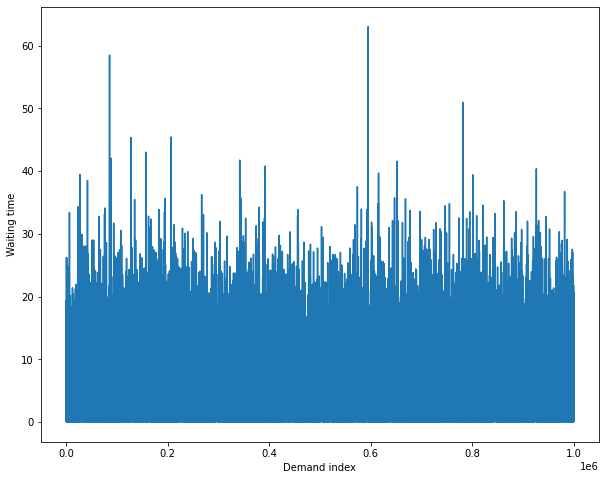

In [21]:
plt.figure(figsize=(10, 8))

plt.plot(range(simulation_demands_amount), result_waiting_times_array)

plt.title('')
plt.xlabel('Demand index')
plt.ylabel('Waiting time')
plt.show()

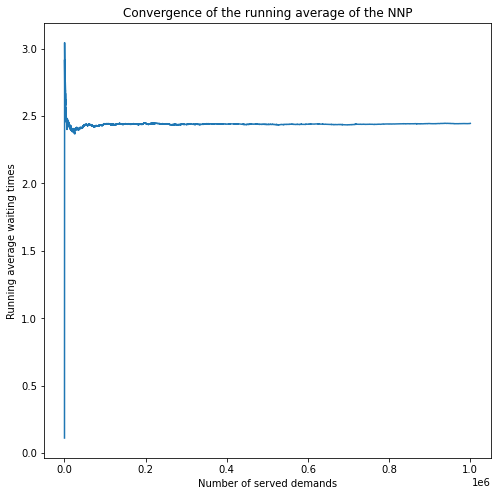

In [22]:
plt.figure(figsize=(8, 8))

plt.plot(range(simulation_demands_amount), convergence)

#plt.ylim(76, 80)
plt.title('Convergence of the running average of the NNP')
plt.xlabel('Number of served demands')
plt.ylabel('Running average waiting times')
plt.show()

## Waiting Times - Batch Means

In [24]:
if (simulation_demands_amount == 400000):
    warm_up_period_min = 200000
    warm_up_period_max = 320000
    sample_size = 3000
elif (simulation_demands_amount == 1000000):
    warm_up_period_min = 500000
    warm_up_period_max = 800000
    sample_size = 7500
else:
    raise ValueError(f"Invalid simulation amount")

number_of_samples = int((warm_up_period_max-warm_up_period_min)/sample_size)
print(f"number of samples = {number_of_samples}")



batch_sample = []
batch_sample_travel = []
batch_sample_number_available = []
for j in range(number_of_samples):
    mean_sample = np.mean(result_waiting_times_array[warm_up_period_min+(j*sample_size):warm_up_period_min+((j+1)*sample_size)])
    batch_sample.append(mean_sample)
    
    mean_sample_travel = np.mean(travel_times_array[warm_up_period_min+(j*sample_size):warm_up_period_min+((j+1)*sample_size)])
    batch_sample_travel.append(mean_sample_travel)
    
    mean_sample_available_nodes = np.mean(number_available_average_array[warm_up_period_min+(j*sample_size):warm_up_period_min+((j+1)*sample_size)])
    batch_sample_number_available.append(mean_sample_available_nodes)
    
CI = [np.mean(batch_sample) - (1.96*statistics.stdev(batch_sample)/np.sqrt(number_of_samples)),np.mean(batch_sample) + (1.96*statistics.stdev(batch_sample)/np.sqrt(number_of_samples))]
variation = (statistics.stdev(batch_sample))

print(f"Waiting time mean = {np.mean(batch_sample):.4f}")
print(f"Sigma waiting time = {variation:.4f}")
print(f"Waiting time CI = [{CI[0]:.4f},{CI[1]:.4f}]")
print(f"\nMean travel time: {np.mean(batch_sample_travel):.4f}")
print(f"Mean number of available demands in system: {np.mean(batch_sample_number_available):.4f}")

number of samples = 40
Waiting time mean = 2.4476
Sigma waiting time = 0.0894
Waiting time CI = [2.4199,2.4752]

Mean travel time: 0.3825
Mean number of available demands in system: 2.0666
